In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

%matplotlib inline

In [2]:
# Convolutional Neural Network
# keras functional API
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Layer
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(1)

/home/inouelab/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
ALPHA = 0.2  # Triplet Loss Parameter

imhight = 128
imwidth = 128

# ネットワーク構造の定義
低層を共有

In [4]:
# shared Layer
shared_Conv1= Conv2D(64, (4,4), padding='same', activation='relu')
shared_MP1= MaxPooling2D(pool_size=(2, 2))

In [5]:
# anchor 
a_in = Input(shape = (imhight, imwidth,3), name='anchor_input')
conv1 = shared_Conv1(a_in)
pool1 = shared_MP1(conv1)
conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dense = Dense(20, activation='relu')(pool2)
a_emb = Flatten(name='anchor_output')(dense)

In [6]:
# positive sample
p_in = Input(shape = (imhight, imwidth,3), name='positive_input')
conv1 =  shared_Conv1(p_in)
pool1 = shared_MP1(conv1)
conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
# conv3 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool2)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
dense = Dense(20, activation='relu')(pool2)
p_emb = Flatten(name='positive_output')(dense)

In [7]:
# negative sample
n_in = Input(shape = (imhight, imwidth,3))
conv1 =  shared_Conv1(n_in)
pool1 = shared_MP1(conv1)
conv2 = Conv2D(32, (4,4) , padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
dense = Dense(20, activation='relu')(pool2)
n_emb = Flatten(name='negative_output')(dense)

## triplet loss計算用のLayerインスタンスをLayerクラスを継承して作成
tensorflow --> numpy ×(error)<br>
numpy --> tensorflow ○<br>
triplet_lossの計算には **tensorflowの書式** を用いる。

In [8]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
    def get_config(self):
        config = {'alpha': self.alpha}
        base_config = super(TripletLossLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

・ numpy配列のリスト、**[a_emb,p_emb,n_emb]のtriplet**を入力とするレイヤーを定義<br>
・ LayerインスタンスとしてModelの中に組み込む<br>
・ Inputインスタンスを指定すると、emb(埋込)までを認識してくれる。

In [9]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([a_emb, p_emb, n_emb])

# Model that can be trained with anchor, positive negative images
tripletNet = Model([a_in, p_in, n_in], triplet_loss_layer)

## ネットワーク構造の可視化

In [10]:
# 画像として出力
plot_model(tripletNet, show_shapes=True,  show_layer_names=False, to_file='tripletNet.png')

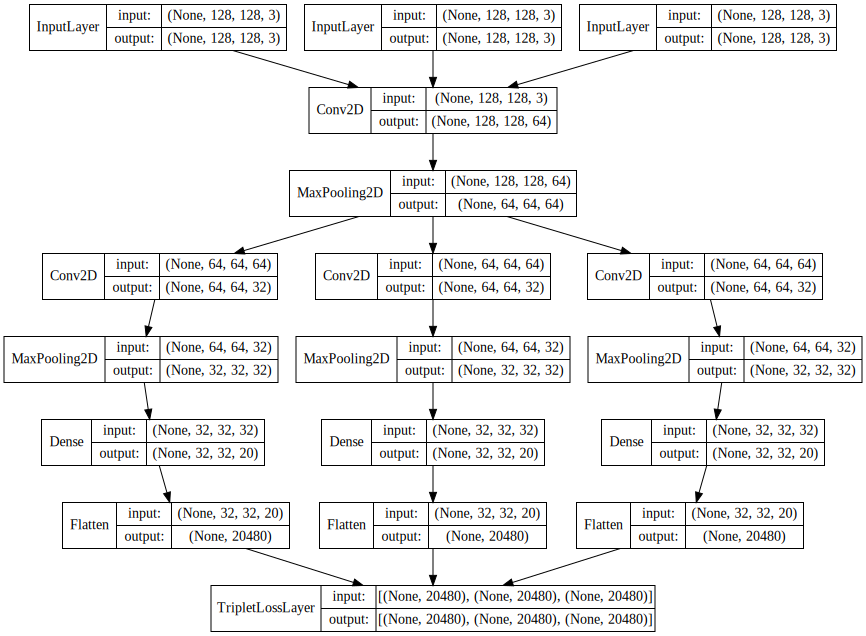

In [11]:
# Jupyter上に構造を出力
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(tripletNet, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

## 動作確認

In [12]:
# sample data
# data_gen.pyからtriplet_generatorを読み込んでsample生成
from data_gen import triplet_generator
generator = triplet_generator()

### モデルのコンパイル

In [13]:
tripletNet.compile(loss=None, optimizer='adam')
# tripletNet.fit_generator(generator=generator, epochs=10, steps_per_epoch=100)

/home/inouelab/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  """Entry point for launching an IPython kernel.


In [14]:
import numpy as np
a_batch = np.random.rand(4, 128, 128, 3)
p_batch = np.random.rand(4, 128, 128, 3)
n_batch = np.random.rand(4, 128, 128, 3)

x = [a_batch,p_batch,n_batch]

In [15]:
# tripletNet=tripletNet.fit(x, epochs=1, steps_per_epoch=100)

In [16]:
np.array(x).shape

(3, 4, 128, 128, 3)

## 簡単なデータセットで実験してみる
いきなりDeepFashionのデータを扱うのではなく、より簡単な画像で実験する。<br>
<del>アニメのキャラ画像でやる。</del><br>
乃木坂の画像でやる。

## 乃木坂の画像をnumpy配列に変更。

In [17]:
import os
from keras.preprocessing.image import array_to_img, img_to_array, list_pictures, load_img # keras library for image to array

In [18]:
# check dataset
os.listdir('nogi_imgs/') 

['shiraishi', 'test', '.DS_Store', 'akimoto', 'the_others', 'ikuta', 'nishino']

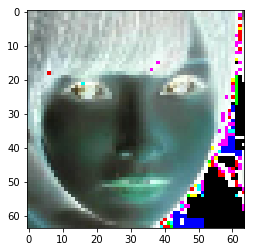

In [19]:
# load_imgを用いるとRGBがおかしくなる？
temp_img = load_img('./nogi_imgs/shiraishi/inputImage2_0.png', target_size=(64,64))
temp_img_array  = img_to_array(temp_img)
plt.imshow(temp_img_array)
plt.show()

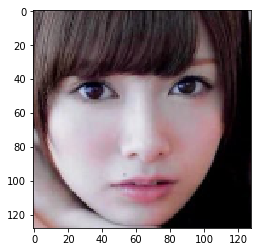

In [20]:
img = plt.imread('./nogi_imgs/shiraishi/inputImage2_0.png')
plt.imshow(img)
plt.show()

In [21]:
type(img)

numpy.ndarray

In [22]:
dir_path = './nogi_imgs/shiraishi/'
others_path = './nogi_imgs/akimoto/'
files = [f for f in sorted(os.listdir(dir_path))]
other_files = [o for o in sorted(os.listdir(others_path))]

同一人物の画像のペアを乱数で生成し、そこに別の人物の画像を加え**triplet**を構成する。<br>
**triplet = [anchor, positive, negative]**が想定されているのでそのようにリストを作成する。

In [23]:
# get anchor and positive image　
pair = np.random.randint(0,len(files),2)
anchor = plt.imread('{0}{1}'.format(dir_path,files[pair[0]]))
positive = plt.imread('{0}{1}'.format(dir_path,files[pair[1]]))

In [24]:
# get negative image
nega_idx = np.random.randint(len(other_files))
negative = plt.imread('{}/{}'.format(others_path,other_files[nega_idx]))

In [25]:
# get triplet
triplet = [anchor, positive, negative] 

## 可視化によるtripletの確認

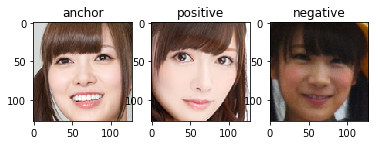

In [26]:
plt.subplot(1,3,1)
plt.imshow(triplet[0])
plt.title('anchor')
plt.subplot(1,3,2)
plt.imshow(triplet[1])
plt.title('positive')
plt.subplot(1,3,3)
plt.imshow(triplet[2])
plt.title('negative')
plt.show()

tripletが生成できていることが判ったため、大量に生成する。

In [27]:
# only name directories
names = [name for name in sorted(os.listdir('./nogi_imgs/'))]
names.remove('.DS_Store')
names.remove('test')
names.remove('the_others')

names

['akimoto', 'ikuta', 'nishino', 'shiraishi']

In [28]:
dir_pathes = []
for name in names:
    dir_pathes.append('./nogi_imgs/{}/'.format(name))

In [29]:
dir_pathes

['./nogi_imgs/akimoto/',
 './nogi_imgs/ikuta/',
 './nogi_imgs/nishino/',
 './nogi_imgs/shiraishi/']

## 各人100個分のtripletを生成。

In [30]:
# method for visualization
def plot_triplet(triplet): 
    plt.subplot(1,3,1)
    plt.imshow(triplet[0])
    plt.title('anchor')
    plt.subplot(1,3,2)
    plt.imshow(triplet[1])
    plt.title('positive')
    plt.subplot(1,3,3)
    plt.imshow(triplet[2])
    plt.title('negative')
    plt.show()

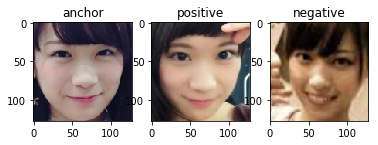

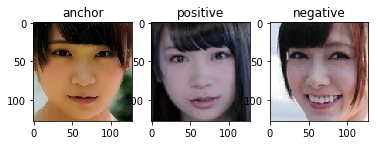

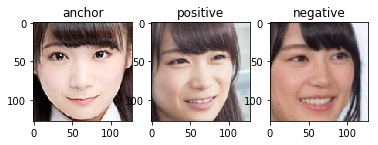

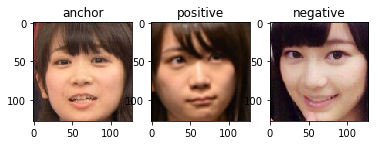

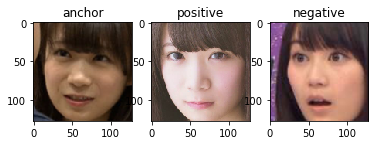

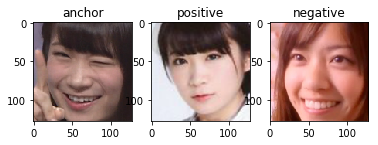

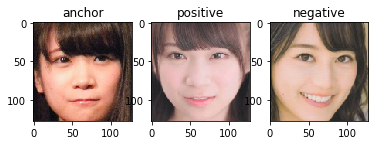

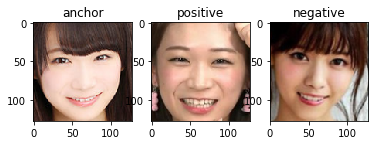

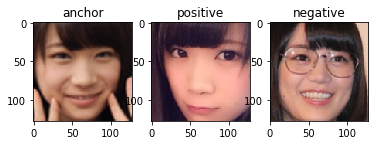

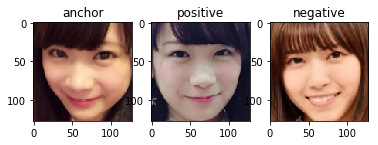

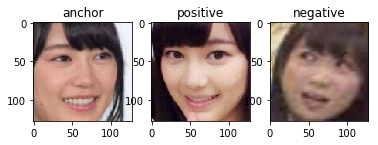

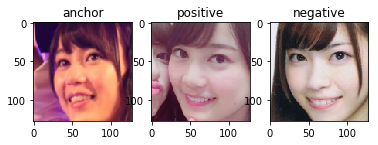

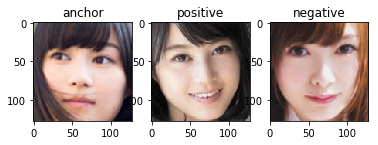

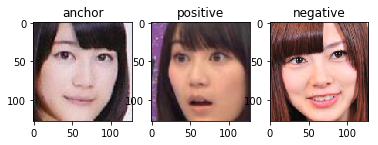

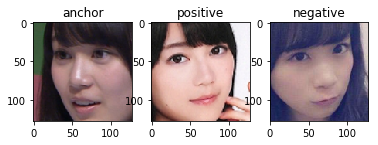

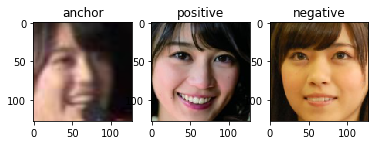

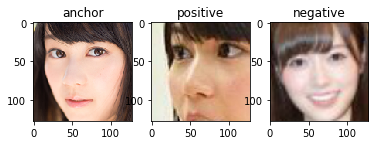

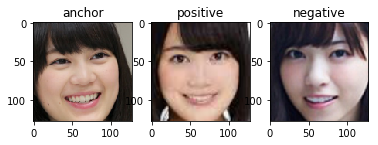

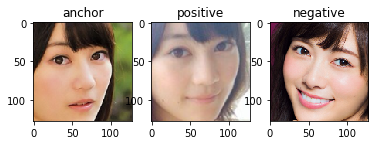

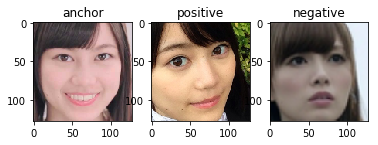

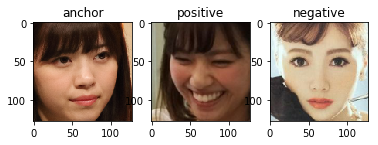

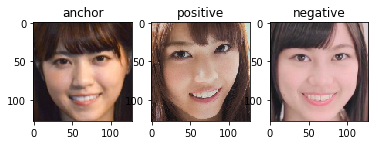

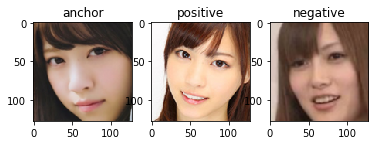

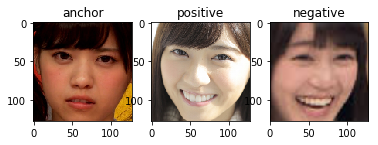

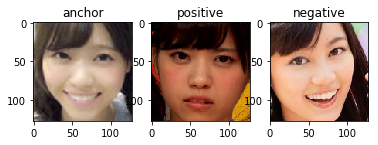

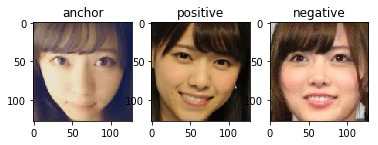

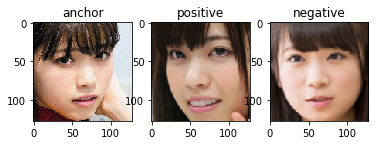

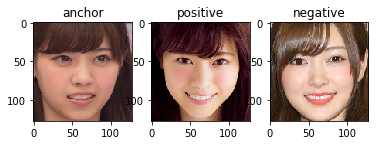

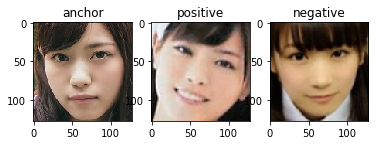

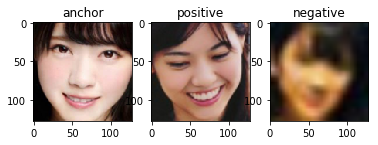

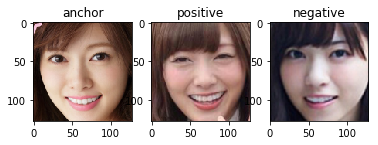

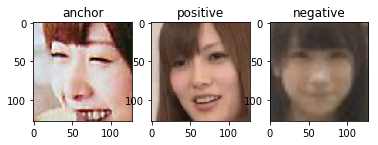

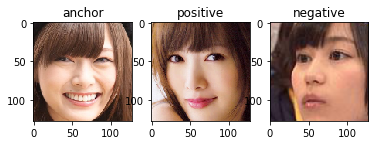

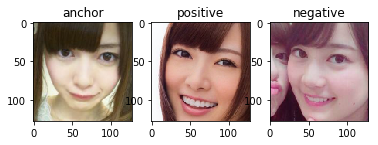

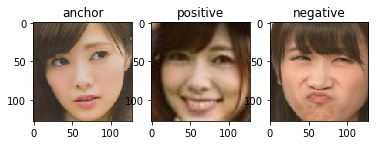

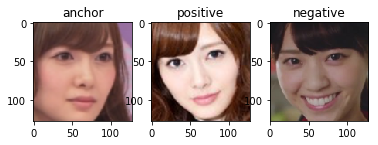

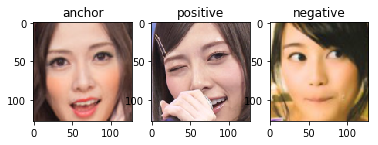

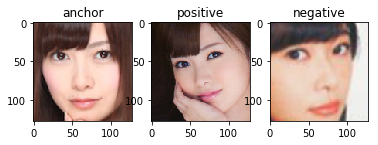

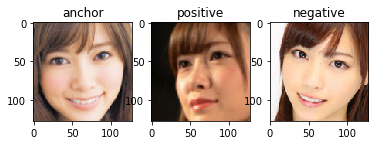

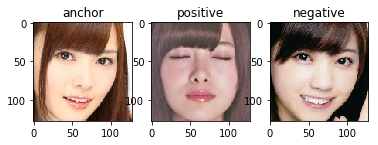

In [42]:
triplets = []
for i in range(len(dir_pathes)):
    # set the files of anchor and positive images
    anc_pos_files = [f for f in sorted(os.listdir(dir_pathes[i]))]
    anc_pos_files.remove('.DS_Store')
    for iteration in range(10):

        # set the files of negative images
        j = random.choice([num for num in range(len(dir_pathes)) if num not in [i]])
        nega_files = [o for o in sorted(os.listdir(dir_pathes[j]))]
        nega_files.remove('.DS_Store')

        # get anchor and positive images as numpy array
        pair = np.random.randint(0,len(anc_pos_files),2)
        anchor = plt.imread('{0}{1}'.format(dir_pathes[i],anc_pos_files[pair[0]]))
        positive = plt.imread('{0}{1}'.format(dir_pathes[i],anc_pos_files[pair[1]]))   

        # get negative images as numpy array
        nega_idx = np.random.randint(len(nega_files))
        negative = plt.imread('{0}{1}'.format(dir_pathes[j],nega_files[nega_idx]))

        # make triplet
        triplet = [anchor, positive, negative]
        
        # visualization
        plot_triplet(triplet)
        
        # append with normalization (0,1)
        triplets.append([anchor/255., positive/255., negative/255.])
        


### triplets を list -> **numpy array** にして扱えるようにする。

In [43]:
triplets = np.array(triplets)
print(triplets.shape)

(40, 3, 128, 128, 3)


In [44]:
# 列を切り出してanchorのテンソル、positiveのテンソル、negativeのテンソルにする。
# 以下はanchorのテンソルの形を確認している。
triplets[:,0].shape

(40, 128, 128, 3)

## モデルのコンパイル及び学習(保存まで)

In [45]:
tripletNet.compile(loss=None, optimizer='adam')
# tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=10, steps_per_epoch=100)
tripletNet.fit([triplets[:,0],triplets[:,1],triplets[:,2]], epochs=1, steps_per_epoch=30)
tripletNet.save('./model/triplet.h5')

/home/inouelab/anaconda3/envs/keras/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  """Entry point for launching an IPython kernel.


Epoch 1/1
30/30 [==============================] - 100s 3s/step - loss: 0.2644


## model(別名)としてロードできるか確認

In [46]:
from keras.models import load_model
model = load_model('./model/triplet.h5',custom_objects={'TripletLossLayer':TripletLossLayer})

/home/inouelab/anaconda3/envs/keras/lib/python3.5/site-packages/keras/models.py:301: UserWarning: Output "triplet_loss_layer" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "triplet_loss_layer" during training.
  sample_weight_mode=sample_weight_mode)


In [47]:
tripletNet.save_weights("./model/triplet.hdf5")

In [48]:
model.load_weights("./model/triplet.hdf5")

## 学習に使っていないデータでpredictし出力の形を確認

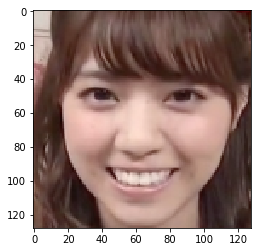

In [49]:
test_img = plt.imread('./nogi_imgs/test/inputImage_0.png')
plt.imshow(test_img)
plt.show()

In [66]:
model.predict([np.expand_dims(test_img/255., axis=0),np.expand_dims(test_img/255., axis=0),np.expand_dims(test_img/255., axis=0)])

array([0.], dtype=float32)

In [55]:
np.expand_dims([test_img/255.,test_img/255.,test_img/255.],axis=0)

array([[[[[3.3525568e-03, 3.1987696e-03, 3.0757401e-03],
          [3.3525568e-03, 3.1833909e-03, 3.0911188e-03],
          [3.3525568e-03, 3.1987696e-03, 3.0911188e-03],
          ...,
          [1.1995387e-03, 1.6916571e-04, 1.8454441e-04],
          [1.1687813e-03, 1.9992310e-04, 1.5378701e-04],
          [1.0611304e-03, 1.0765091e-04, 4.6136101e-05]],

         [[3.3525568e-03, 3.1987696e-03, 3.0757401e-03],
          [3.3371781e-03, 3.1833909e-03, 3.0911188e-03],
          [3.3525568e-03, 3.1987696e-03, 3.0911188e-03],
          ...,
          [9.9961564e-04, 1.6916571e-04, 1.2302962e-04],
          [9.0734335e-04, 1.0765091e-04, 4.6136101e-05],
          [9.3810074e-04, 1.2302962e-04, 3.0757405e-05]],

         [[3.3525568e-03, 3.1987696e-03, 3.0757401e-03],
          [3.3371781e-03, 3.1987696e-03, 3.0911188e-03],
          [3.3525568e-03, 3.1987696e-03, 3.0911188e-03],
          ...,
          [8.6120726e-04, 1.8454441e-04, 1.0765091e-04],
          [8.1507111e-04, 1.3840832e-04